In [1]:
import json
import random
import uuid
import numpy as np
import time
import requests
import traceback
import math
import ast
import pandas as pd
from qwikidata.linked_data_interface import get_entity_dict_from_api
from qwikidata.sparql import return_sparql_query_results
import sqlite3

In [2]:
target_languages = ['sv', 'nl', 'ja']#['en','es','pt','sv', 'nl', 'ja']

# Functions

In [3]:
def get_entity(item_id):
    while True:
        try:
            entity = get_entity_dict_from_api(item_id)
            return entity
        except ConnectionError:
            #traceback.print_exc()
            continue
        except MaxRetryError:
            #traceback.print_exc()
            time.sleep(1)
        except LdiResponseNotOk:
            #traceback.print_exc()
            return 'deleted'

def get_label(item):
    if type(item) == str:
        entity = get_entity(item)
        if entity == 'deleted':
            return entity
        labels = entity['labels']
    elif type(item) == dict:
        labels = item['labels']
    languages = ['en','fr','es','pt','pt-br','it','de']
    for l in languages:
        if l in labels:
            return labels[l]['value']
    return 'no-label'

def get_datatype(item):
    try:
        if type(item) == str:
            entity = get_entity(item)
            if entity == 'deleted':
                return entity
            datatype = entity['datatype']
        elif type(item) == dict:
            datatype = item['datatype']
        return datatype
    except KeyError:
        return 'none'

def get_claim_values_of(item, property_id):
    if type(item) == str:
        entity = get_entity(item)
        if entity == 'deleted':
            return entity
        claims = entity['claims']
    elif type(item) == dict:
        claims = item['claims']
    if property_id in claims:
        instance_of_claims = claims[property_id]
        return [i['mainsnak']['datavalue']['value']['id'] for i in instance_of_claims]
    else:
        return []
    
def aggregate_other(df, by, count_name='count', other_thr=1):
    df_c = df.copy()
    df_c = df_c[[by,count_name]]
    total_count = df_c[count_name].sum()
    df_c['per'] = df_c[count_name].apply(lambda x: 100*x/total_count)

    other_df_c = df_c[df_c['per'] < other_thr].sum()
    other_df_c[by] = 'other'

    df_c = df_c.append(
        other_df_c, ignore_index=True
    ).sort_values('per',ascending=False).reset_index(drop=True)
    df_c = df_c[df_c['per'] >= other_thr]

    return df_c

def query_sparql_endpoint(sparql_query):
    wikidata_sparql_url = 'https://query.wikidata.org/sparql'
    while True:
        res = requests.get(wikidata_sparql_url, params={"query": sparql_query, "format": "json"})
        if res.status_code == 429:
            time.sleep(1)
            continue
        elif res.status_code == 200:
            return res.json()
        else:
            raise Exception
            

In [4]:
def convert_ref_node_text_to_pairs(ref_node_string):
    try:
        if type(ref_node_string) == list:
            ref_node = ref_node_string
        elif type(ref_node_string) == str:
            ref_node = ast.literal_eval(ref_node_string)
        pairs = {}
        for e in ref_node:
            prop_label = get_label(e[1])
            prop_label = prop_label.replace('.','[dot]')
            prop_label = prop_label.replace('$','[dollar-sign]')
            if e[3] == 'wikibase-item':
                prop_value_id = ast.literal_eval(e[4])['value']['id']
                prop_value_label = get_label(prop_value_id)
                prop_value_label = prop_value_label.replace('.','[dot]')
                prop_value_label = prop_value_label.replace('$','[dollar-sign]')
                #prop_value_url = 'http://www.wikidata.org/entity/' + prop_value_id
                pairs[prop_value_label] = 'wikibase-item:>' + prop_value_label + '->' + prop_value_id
            elif e[3] == 'time':
                prop_value_time = ast.literal_eval(e[4])['value']['time']
                pairs[prop_label] = 'time:>' + prop_value_time
            elif e[3] == 'url':
                prop_value_url = ast.literal_eval(e[4])['value']
                pairs[prop_label] = 'url:>' + prop_value_url
            elif e[3] == 'monolingualtext':
                prop_value_url = ast.literal_eval(e[4])['value']['text']
                pairs[prop_label] = 'value:>' + prop_value_url
            else:
                prop_value_val = ast.literal_eval(e[4])['value']
                pairs[prop_label] = 'value:>' + prop_value_val

        return pairs
    except Exception:
        traceback.print_exc()
        print(ref_node)
        print(type(ref_node))
        return None

In [5]:
def convert_microtask_dataframe_to_json_set(df):
    microtask_jsons = []
    try:
        for row_number, row_content in df.iterrows():
            sparql_query=''
            sparql_results=''
            # GET VALUES ALREADY IN ROW
            print('{}%'.format((row_number+1)/df.shape[0]*100) + ' '*15, end='\r')
            microtask_json = {
                'reference_id': row_content['reference_id'],
                'url': row_content['url'],
                'ref_node_pairs' : ast.literal_eval(row_content['ref_node_pairs'])\
                    if type(row_content['ref_node_pairs']) == str else row_content['ref_node_pairs'],
                'language_crawl': row_content['language_crawl']
            }
            # GET A RANDOM AVAILABLE STATEMENT USING THIS REFERENCE
            sparql_query = '''
                select ?sLabel
                where {
                 ?s prov:wasDerivedFrom wdref:$1.
                 SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                }
            '''.replace('$1',row_content['reference_id'])
            sparql_results = query_sparql_endpoint(sparql_query)['results']['bindings']
            if len(sparql_results) == 0:
                continue
            statement_node = random.choice(sparql_results)['sLabel']['value'].split('statement/')[1]

            # GET THE SUBJECT, PREDICATE AND OBJECT LABELS OF THIS STATEMENT
            sparql_query = '''
            select ?sLabel ?ppLabel ?oLabel
            where {
             ?s ?p wds:$1.
             ?pp wikibase:claim ?p;
                 wikibase:statementProperty ?ps.
             wds:$1 ?ps ?o.
             SERVICE wikibase:label { bd:serviceParam wikibase:language "$2, en". }
            }
            '''.replace('$1', statement_node).replace('$2',microtask_json['language_crawl'])
            sparql_results = query_sparql_endpoint(sparql_query)['results']['bindings'][0]

            microtask_json['statement_node'] = statement_node
            microtask_json['subject'] = sparql_results['sLabel']['value']
            microtask_json['predicate'] = sparql_results['ppLabel']['value']
            microtask_json['object'] = sparql_results['oLabel']['value']

            # GENERATE A 'ZERO' GOLDEN SET ID, TO SHOW THAT THIS IS NOT PART OF THE GOLDEN DATA
            # IF IT IS, EDIT THIS ON THE JSON MANUALLY
            microtask_json['g_id'] = 0

            microtask_jsons.append(microtask_json)
            if len(microtask_jsons) == 385:
                break
        return microtask_jsons
    except Exception:
        print(row_content)
        print(sparql_query)
        print(sparql_results)
        traceback.print_exc()
        raise

## Sampling

According to the results at the end of the Analysis, we see that a representative sample with a 95.0% confidence level and a 5.0% margin would have to be at least of size 385 for any given language. 

So for each target language we take a sample of 385 random reference ids and create dataframes with their *joined data* from the tables **reference_nodes_to_urls** and **reference_urls_parsed**.

In [6]:
wikidata_db_processed = sqlite3.connect('/mnt/data/group3/wikidata/part/wikidata_processed_apr.db')
cursor = wikidata_db_processed.cursor()

In [7]:
# FOR EACH TARGET LANGUAGE, GET AT MOST 385 REFERENCE IDS THAT WERE CRAWLED 
target_sample_size = 390# we get a bit more than 385 to account for failures in extracting the data
target_language_samples = {}
for lan in target_languages:
    cursor.execute('''
        select reference_id
        from reference_urls_parsed
        where language_crawl == '{}'
        and code == 200
    '''.format(lan))
    target_language_reference_ids = cursor.fetchall()
    print('Selecting {} out of {} references on language {}.'.format(
        target_sample_size, len(target_language_reference_ids), lan
    ))
    random.seed(42)
    target_language_samples[lan] = [v[0] for v in random.sample(
        target_language_reference_ids, target_sample_size
    )]

Selecting 390 out of 189730 references on language en.
Selecting 390 out of 1561 references on language es.
Selecting 390 out of 1393 references on language sv.
Selecting 390 out of 439 references on language pt.
Selecting 390 out of 1522 references on language nl.
Selecting 390 out of 444 references on language ja.


## Step 3: Turning the string version of the node into a JSON object

For each **sampled** reference id in the *joined* table, we do the following.

In: The ref_node field <br>
Out: A paired json format of the reference node

We add this formatted json to the *joined* table

In the end, for each target language, we have a data frame representing the complete *joined* table for that language.

In [124]:
target_language_datasets = {}
for lan in target_languages:
    if len(target_language_samples[lan]) == target_sample_size:
        print('Joining sampled entries for language:',lan)
        target_language_datasets[lan] = []
        for i, reference_id in enumerate(target_language_samples[lan]):
            print('{}%'.format((i+1)/target_sample_size*100) + ' '*15, end='\r')
            cursor.execute('''
                select * from reference_nodes_to_urls where reference_id =='{}'
            '''.format(reference_id))
            reference_nodes_to_urls = cursor.fetchall()[0]
            
            res = {
                'reference_id':reference_id,
                'url':reference_nodes_to_urls[1],
                'url_type': reference_nodes_to_urls[2],
                'is_inferred_from': reference_nodes_to_urls[3],
                'stated_in': reference_nodes_to_urls[4],
                'external_id_prop': reference_nodes_to_urls[5],
                'external_id': reference_nodes_to_urls[6],
                'internal_urls': reference_nodes_to_urls[7],
                'external_url': reference_nodes_to_urls[8],
                'wikimedia_import_urls': reference_nodes_to_urls[9],
                'retrieved': reference_nodes_to_urls[10],
                'publication_date': reference_nodes_to_urls[11],
                'ref_node': reference_nodes_to_urls[12]
            }
            
            cursor.execute('''
                select * from reference_urls_parsed where reference_id =='{}'
            '''.format(reference_id))
            reference_urls_parsed = cursor.fetchall()[0]
            
            assert(reference_nodes_to_urls[0] == reference_urls_parsed[0])
            assert(reference_nodes_to_urls[1] == reference_urls_parsed[1])
            
            res['error_msg'] = reference_urls_parsed[2]
            res['code'] = reference_urls_parsed[3]
            res['content-type'] = reference_urls_parsed[4]
            res['final_url'] = reference_urls_parsed[5]
            res['reason'] = reference_urls_parsed[6]
            res['language_crawl'] = reference_urls_parsed[7]
            
            res['ref_node_pairs'] = convert_ref_node_text_to_pairs(res['ref_node'])
            
            target_language_datasets[lan].append(res)
        target_language_datasets[lan] = pd.DataFrame(target_language_datasets[lan])
    else:
        continue

Joining sampled entries for language: en
Joining sampled entries for language: es
Joining sampled entries for language: nl
Joining sampled entries for language: sv
Joining sampled entries for language: pt
Joining sampled entries for language: ja


See the table for English:

In [127]:
target_language_datasets['en']

,reference_id,url,url_type,is_inferred_from,stated_in,external_id_prop,external_id,internal_urls,external_url,wikimedia_import_urls,retrieved,publication_date,ref_node,error_msg,code,content-type,final_url,reason,language_crawl,ref_node_pairs
0,a4e7281c6909b7cb2dc251f84627a41204abe07e,https://viaf.org/viaf/64195194,internal_url,None,Q54919,P214,64195194,['https://viaf.org/viaf/64195194'],None,[],"{'time': '+2017-10-16T00:00:00Z', 'timezone': ...",None,"[('a4e7281c6909b7cb2dc251f84627a41204abe07e', ...",none,200,text/html,https://viaf.org/viaf/64195194/,OK,en,"{'VIAF ID': 'value:>64195194', 'retrieved': 't..."
1,eec01187c078f8e4994ae4edd38a7e8c1a300233,https://www.ebi.ac.uk/europepmc/webservices/re...,external_url,None,Q5412157,P698,23666324,"['https://pubmed.ncbi.nlm.nih.gov/23666324', '...",https://www.ebi.ac.uk/europepmc/webservices/re...,[],"{'time': '+2020-03-01T00:00:00Z', 'timezone': ...",None,"[('eec01187c078f8e4994ae4edd38a7e8c1a300233', ...",none,200,application/json;charset=UTF-8,https://www.ebi.ac.uk/europepmc/webservices/re...,OK,en,{'stated in': 'wikibase-item:>Europe PubMed Ce...
2,5fcb9535013745aa366695b0ad4447f5cd7d3224,https://www.ebi.ac.uk/europepmc/webservices/re...,external_url,None,Q5412157,P698,22832743,"['https://pubmed.ncbi.nlm.nih.gov/22832743', '...",https://www.ebi.ac.uk/europepmc/webservices/re...,[],"{'time': '+2020-02-09T00:00:00Z', 'timezone': ...",None,"[('5fcb9535013745aa366695b0ad4447f5cd7d3224', ...",none,200,application/json;charset=UTF-8,https://www.ebi.ac.uk/europepmc/webservices/re...,OK,en,{'stated in': 'wikibase-item:>Europe PubMed Ce...
3,a10885a0cc7258364dd9f3b7cc39491d3793aa4d,https://www.ebi.ac.uk/europepmc/webservices/re...,external_url,None,Q5412157,P698,18824271,"['https://pubmed.ncbi.nlm.nih.gov/18824271', '...",https://www.ebi.ac.uk/europepmc/webservices/re...,[],"{'time': '+2020-01-14T00:00:00Z', 'timezone': ...",None,"[('a10885a0cc7258364dd9f3b7cc39491d3793aa4d', ...",none,200,application/json;charset=UTF-8,https://www.ebi.ac.uk/europepmc/webservices/re...,OK,en,{'stated in': 'wikibase-item:>Europe PubMed Ce...
4,6831ccb51015d8641bff0db303fd8e21dc342c67,https://api.crossref.org/works/10.1111%2FPALA....,external_url,None,Q5188229,None,None,None,https://api.crossref.org/works/10.1111%2FPALA....,[],"{'time': '+2018-01-21T00:00:00Z', 'timezone': ...",None,"[('6831ccb51015d8641bff0db303fd8e21dc342c67', ...",none,200,application/json;charset=UTF-8,https://api.crossref.org/works/10.1111%2FPALA....,OK,en,{'stated in': 'wikibase-item:>Crossref->Q51882...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,ffa9df9f0a8189d442d24b00c7b5fa8b26a03ccf,https://www.ncbi.nlm.nih.gov/gene/888781,internal_url,None,Q20641742,P351,888781,['https://www.ncbi.nlm.nih.gov/gene/888781'],None,[],"{'time': '+2020-03-07T00:00:00Z', 'timezone': ...",None,"[('ffa9df9f0a8189d442d24b00c7b5fa8b26a03ccf', ...",none,200,text/html; charset=UTF-8,https://www.ncbi.nlm.nih.gov/gene/888781,OK,en,{'stated in': 'wikibase-item:>NCBI Gene->Q2064...
386,298430d68b58c18aba0ed9796e849eb200d2cf89,http://www.ebi.ac.uk/QuickGO/annotations?geneP...,external_url,None,Q28018111,P352,Q89EV3,['http://purl.uniprot.org/uniprot/Q89EV3'],http://www.ebi.ac.uk/QuickGO/annotations?geneP...,[],"{'time': '+2019-02-14T00:00:00Z', 'timezone': ...",None,"[('298430d68b58c18aba0ed9796e849eb200d2cf89', ...",none,200,text/html; charset=UTF-8,https://www.ebi.ac.uk/QuickGO/annotations?gene...,OK,en,"{'retrieved': 'time:>+2019-02-14T00:00:00Z', '..."
387,13815ed749bcaf0dc36b3caefa446f873a7dc0bb,https://www.ebi.ac.uk/europepmc/webservices/re...,external_url,None,Q5412157,P698,5851379,"['https://pubmed.ncbi.nlm.nih.gov/5851379', 'h...",https://www.ebi.ac.uk/europepmc/webservices/re...,[],"{'time': '+2019-10-27T00:00:00Z', 'timezone': ...",None,"[('13815ed749bcaf0dc36b3caefa446f873a7dc0bb', ...",none,200,application/json;charset=UTF-8,https://www.ebi.ac.uk/europepmc/webservices/re...,OK,en,{'stated in': 'wikibase-item

## Step 4: Turning the final sampled dataframes into json sets

For each joined table (there is one for each target language), we convert the entries into json data that is ready to be annotated and sent to the workers.

In [126]:
#target_language_jsonsets = {}
for lan in target_language_datasets.keys():
    if lan in target_language_jsonsets:
        if len(target_language_jsonsets[lan]) == 385:# We limit here the 390 to 385 for which we extract the info
            print('Already converted language',lan)
            continue
    print('Converting language',lan)
    target_language_jsonsets[lan] = convert_microtask_dataframe_to_json_set(target_language_datasets[lan])
    print('Final number of samples:',len(target_language_jsonsets[lan]))

Converting language en
Final number of samples: 385      
Converting language es
Final number of samples: 385      
Converting language nl
Final number of samples: 385      
Converting language sv
Final number of samples: 385      
Converting language pt
Final number of samples: 385      
Converting language ja
Final number of samples: 385      


# Separate Gold Standard

We now split the json sets into two, one with golden standards and one with references to be judged.

Here is we calculate an appropriate number of gold standards:
- Let X be the maximum expected number of tasks any singular worker can complete;
- Let Y be the number of gold standard references we have annotated;
- Let Z be the number of combinations of 2 gold standard references that we can take from the Y gold standard references in our gold set, regardless of pairing order, without repeating.
- Let P be the probability of a worker doing X tasks and not finding a repeated pair of golden standard references, taken from the set of Z gold standard pairs.

So we calculate:
- Z = Y*(Y-1)/2
- P = Z!/((Z^X)*(Z-X)!)

So, we set X = 15 (The mean number of tasks per worker for previous experiments has been 4, with standard deviation of 10.5, so if it follows a normal distribution, we get 85% of workers here).

According to the calculation below, we see that **Y = 45** gives us near 90% of chances of not having repeated gold standard, so that is how many gold standards we aim at annotating for each language

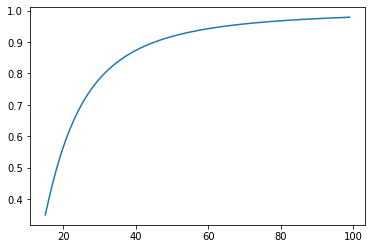

In [153]:
from decimal import Decimal
from decimal import *
import matplotlib.pyplot as plt
def fac(x):
    return Decimal(math.factorial(x))
x = 15
ys = list(range(15,100))
zs = [y*(y-1)/2 for y in ys]
ps = [fac(z)/(Decimal(z**x)*fac(z-x)) for z in zs]
plt.plot(ys,ps)

In [132]:
golden_standard_quota = 45

for lan in target_language_jsonsets.keys():
    print('Saving files for',lan)
    with open('data/final/sampled_references_{}_gd.json'.format(lan),'w+',encoding='utf8') as f:
        json.dump(target_language_jsonsets[lan][:golden_standard_quota], f, indent=2,ensure_ascii=False)
    with open('data/final/sampled_references_{}.json'.format(lan),'w+',encoding='utf8') as f:
        json.dump(target_language_jsonsets[lan][golden_standard_quota:], f, indent=2,ensure_ascii=False)

Saving files for en
Saving files for es
Saving files for nl
Saving files for sv
Saving files for pt
Saving files for ja


You must now annotate the golden standard by doing the following:
For each gd reference in the gd json set, go to the "gd" field, which should be like this:
```
{
    "reference_id": [random uuid],
    "url": [an url],
    ...,
    "g_id": 0
}
```

and change it to something of the format:

```
{
    "reference_id": [random uuid],
    "url": [an url],
    ...,
    "g_id": {
        "relevance": {
          "is_present": [0 if it is not present, 1 if it is],
          "difficulty":[a list of numbers from 0 to 4, with 0 to 4 simbolizing possible difficulty answers as seen in the task mockup. Can also be just -1 if it does not matter.],
          "reason":[a list of numbers from 0 to 6, with 0 to 6 simbolizing possible reason answers as seen in the task mockup. Can also be just -1 if it does not matter.]
        },
        "authorit":{
          "author": [a number from 0 to 2 simbolizing the author type as seen in the task mockup],
          "publisher": [a number from 0 to 4 simbolizing the publisher type as seen in the task mockup],
          "sub_publisher": [a number from 0 to the amount of subpublisher types for this publisher type, simbolizing the subpublisher type as seen in the task mockup. It can also be -1 if you don't care for this field.]
        }
    }
}
```

# Generating Task Sets

**Make sure you have annotated the GD before proceeding here**

**Make sure you have also filtered the non-GD for API-verifiable examples**

Now we take 4 non_gd references and 2 gd references and pack them into task sets of 6

In [6]:
maxSingleInstances = 1 #MAX TIMES ANY REFERENCE APPEARS AMONG THE TASK SETS

def getRandomTask(counter, n, non_gd_references):
    p = [max(maxSingleInstances-c,0.0001) for c in counter]
    p = [pp/sum(p) for pp in p]
    indexes = np.random.choice(
        a = list(range(len(non_gd_references))),
        size=n,
        replace=False,
        p=p
    )        
    task = []
    for i in indexes:
        reference = non_gd_references[i]
        task.append((reference,i))
    return task

def getRandomGoldenTask(n, gd_references):
    indexes = np.random.choice(
        a = list(range(len(gd_references))),
        size=n,
        replace=False
    )
    task = []
    for i in indexes:
        reference = gd_references[i]
        task.append(reference)
    return task

def generateTaskSet(counter, non_gd_references, gd_references, n=(4,2)):
    '''
    counter = a counter which keeps track of how many times each reference was retrieved
    n = (x,y) where x = number of non_gd references and y = number of gd references
    '''
    taskSet = []
    task = getRandomTask(counter, n[0], non_gd_references)
    taskSet += [r for (r,i) in task] # pairs reference,index are generated here, so that we can update the counter later
    taskSet += getRandomGoldenTask(n[1], gd_references)
    random.shuffle(taskSet)
    return taskSet, [i for (p,i) in task] # we return indices here to update counter


def generateIDdTaskSets(non_gd_references, gd_references):
    counter = [0]*len(non_gd_references)
    taskSets = []
    while (any([c < maxSingleInstances for c in counter])):
        taskSet, indexes = generateTaskSet(counter, non_gd_references, gd_references)
        taskSetIDd = {
            '_id': str(uuid.uuid4()),
            'taskSet' : taskSet
        }
        taskSets.append(taskSetIDd)
        for i in indexes:
            counter[i] = counter[i] + 1
    return taskSets, counter

## RELEVANCY SETS

In [9]:
target_language_deploy = ['sv','nl','ja']
for lan in target_language_deploy:
    print('Generating Task Sets for:',lan)
    with open('data/final/gd_annotations/sampled_references_{}_gd.json'.format(lan),'r',encoding='utf8') as f:
        gd_references = json.load(f)
        print('Gd len:',len(gd_references))
    with open('data/final/non_gd_filtered_sampled_references/filtered_sampled_references_{}_rel.json'.format(lan),'r',encoding='utf8') as f:
        non_gd_references = json.load(f)
        print('Non-Gd len:',len(non_gd_references))
        
    ds, c = generateIDdTaskSets(non_gd_references, gd_references)
    print('Generated {} tasks, each reference appearece counter is: {}'.format(len(ds), c))
    
    with open('./data/final/TaskSets/TaskSets_{}_rel.json'.format(lan),'w+') as f:
        json.dump(ds,f,indent=2)

Generating Task Sets for: sv
Gd len: 45
Non-Gd len: 113
Generated 29 tasks, each reference appearece counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Generating Task Sets for: nl
Gd len: 45
Non-Gd len: 312
Generated 78 tasks, each reference appearece counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## AUTHORITATIVENESS SETS

To generate them, go to the filtered sampled relevance files, create copies with \_auth instead of \_rel at the end of the filename, and remove wikipedia-domain references. They bloat the samples and we already know their labels, we don't need the crowd for them.

In [10]:
for lan in target_language_deploy:
    print('Generating Task Sets for:',lan)
    with open('data/final/gd_annotations/sampled_references_{}_gd.json'.format(lan),'r',encoding='utf8') as f:
        gd_references = json.load(f)
        print('Gd len:',len(gd_references))
    with open('data/final/non_gd_filtered_sampled_references/filtered_sampled_references_{}_auth.json'.format(lan),'r',encoding='utf8') as f:
        non_gd_references = json.load(f)
        print('Non-Gd len:',len(non_gd_references))
        
    ds, c = generateIDdTaskSets(non_gd_references, gd_references)
    print('Generated {} tasks, each reference appearece counter is: {}'.format(len(ds), c))
    
    with open('./data/final/TaskSets/TaskSets_{}_auth.json'.format(lan),'w+') as f:
        json.dump(ds,f,indent=2)

Generating Task Sets for: sv
Gd len: 45
Non-Gd len: 60
Generated 15 tasks, each reference appearece counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Generating Task Sets for: nl
Gd len: 45
Non-Gd len: 301
Generated 76 tasks, each reference appearece counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,